<a href="https://colab.research.google.com/github/eolson615/SpringboardDSCareerTrack/blob/master/Capstone2_year1model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In this notebook I train and test both a LogisticRegression model and a RandomForesetClassifier model with the data from those customers who have been with Telco for 12 months or less. Chose this sub-group of customers because during the EDA process (see Capstone2_EDA notebook), I noted that a significant number of customer Churn happened within the first year of the customer being with Telco and of the customers who are in this sub-group almost half of them ended up leaving Telco. 

#I hoped modeling this sub-group of customers would do two things:
#1) Because the ratio of 'Yes' and 'No' churn customers was close to 50% (it was actually No=53% and Yes=47%), then this would give a natural solution to the imbalance data issue without having to either oversample or undersample the data.
#2) Provide a greater accuracy and Yes recall for this group. This could help Telco identify with greter efficiency customers who might leave earlier.


In [26]:
import warnings  #This was added for aesthetics on GitHub and was not implemented during the composition of this notebook
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

In [27]:
df_url = 'https://raw.githubusercontent.com/eolson615/SpringboardDSCareerTrack/master/Capstone2/Data/telcodata_posteda.csv'
df = pd.read_csv(df_url, index_col=[0])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [28]:
df_1yr = df.loc[df['tenure'] <= 12, :]
df_1yr.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No


In [29]:
df_1yr.shape

(2186, 20)

In [30]:
print(df_1yr.Churn.value_counts(normalize=True))
print(df_1yr.Churn.value_counts())
print(df.Churn.value_counts())
print('\n')
print('Percent of total Yes Churn that happen within the first year was', (df_1yr.Churn.value_counts().Yes) /  (df.Churn.value_counts().Yes))

No     0.525618
Yes    0.474382
Name: Churn, dtype: float64
No     1149
Yes    1037
Name: Churn, dtype: int64
No     5174
Yes    1869
Name: Churn, dtype: int64


Percent of total Yes Churn that happen within the first year was 0.5548421615837347


##After creating a DataFrame with the customers who had been with Telco for 12 or fewer months, I train test split the data. Before using the data on the LogisticRegression model, I use get_dummies and StandardScaler for the categorical and numeric data respectively. I use classification report, confusion matrix, and coef to analyze how well the model fits the data.

In [31]:
X = df_1yr.drop(columns='Churn')
y = pd.Series(df_1yr.Churn.map(dict(Yes=1, No=0)))
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=56, stratify=y)
print('Xtrain', type(Xtrain), Xtrain.shape, Xtrain)
print('\n')
print("Xtrest", type(Xtest), Xtest.shape, Xtest)
print('\n')
print('ytrain', type(ytrain), ytrain.shape, ytrain)
print('\n')
print("ytrest", type(ytest), ytest.shape, ytest)

Xtrain <class 'pandas.core.frame.DataFrame'> (1639, 19)       gender  SeniorCitizen  ... MonthlyCharges TotalCharges
6569  Female              0  ...          19.50       162.15
3989  Female              0  ...          38.50       330.80
1716    Male              0  ...          54.75       438.05
687     Male              1  ...          49.25        91.10
2413    Male              0  ...          49.65       305.55
...      ...            ...  ...            ...          ...
5986    Male              1  ...          79.15       827.70
3847    Male              0  ...          20.00       198.60
1434    Male              0  ...          99.95      1132.75
4214    Male              0  ...          90.05       368.10
439     Male              0  ...          55.05        55.05

[1639 rows x 19 columns]


Xtrest <class 'pandas.core.frame.DataFrame'> (547, 19)       gender  SeniorCitizen  ... MonthlyCharges TotalCharges
4794    Male              0  ...          19.35        46.35
801   F

In [32]:
print("ytrain")
print(ytrain.value_counts(normalize=True))
print('ytest')
print(ytest.value_counts(normalize=True))

ytrain
0    0.52532
1    0.47468
Name: Churn, dtype: float64
ytest
0    0.526508
1    0.473492
Name: Churn, dtype: float64


In [33]:
X.select_dtypes(include=['float64', 'int64']).columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [34]:
cat_features = X.select_dtypes(include=['object']).columns
num_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Xtrain_dummies = pd.get_dummies(Xtrain, columns=cat_features, drop_first=True)
Xtest_dummies = pd.get_dummies(Xtest, columns=cat_features, drop_first=True)
column_trans = make_column_transformer((StandardScaler(), num_features), remainder='passthrough')
logreg_standard = LogisticRegression()
logreg_pipeline_standard = make_pipeline(column_trans, logreg_standard)
logreg_pipeline_standard.fit(Xtrain_dummies, ytrain)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges'])],
                                   verbose=False)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, inter

In [35]:
ypred_train_standard = logreg_pipeline_standard.predict(Xtrain_dummies)
ypred_test_standard = logreg_pipeline_standard.predict(Xtest_dummies)
class_report_ypred_train_standard = classification_report(ytrain, ypred_train_standard)
class_report_ypred_test_standard = classification_report(ytest, ypred_test_standard)
print('class_report_ypred_train_standard')
print(class_report_ypred_train_standard)
print('class_report_ypred_test_standard')
print(class_report_ypred_test_standard)

class_report_ypred_train_standard
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       861
           1       0.70      0.74      0.72       778

    accuracy                           0.72      1639
   macro avg       0.72      0.73      0.72      1639
weighted avg       0.73      0.72      0.73      1639

class_report_ypred_test_standard
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       288
           1       0.70      0.68      0.69       259

    accuracy                           0.71       547
   macro avg       0.71      0.71      0.71       547
weighted avg       0.71      0.71      0.71       547



In [36]:
cnf_matrix_train_standard_logreg = confusion_matrix(ytrain, ypred_train_standard)
cnf_matrix_test_standard_logreg = confusion_matrix(ytest, ypred_test_standard)
print('cnf_matrix_train_standard_logreg')
print(cnf_matrix_train_standard_logreg)
print('cnf_matrix_test_standard_logreg')
print(cnf_matrix_test_standard_logreg)

cnf_matrix_train_standard_logreg
[[616 245]
 [206 572]]
cnf_matrix_test_standard_logreg
[[212  76]
 [ 83 176]]


In [37]:
df_X_dummies_column = pd.melt(pd.DataFrame(data=Xtrain_dummies.columns)).drop(columns='variable')
standard_logreg_coef = pd.melt(pd.DataFrame(data=logreg_standard.coef_)).drop(columns='variable')
standard_logreg_coef_withnames = standard_logreg_coef.join(df_X_dummies_column, how='outer', rsuffix='feature').sort_values(by=['value'], ignore_index=True)
standard_logreg_coef_withnames

,value,valuefeature
0,-2.039351,Contract_Two year
1,-0.758099,Contract_One year
2,-0.752817,tenure
3,-0.422094,TechSupport_Yes
4,-0.374305,PhoneService_Yes
5,-0.373600,OnlineSecurity_Yes
6,-0.335407,OnlineBackup_Yes
7,-0.315903,PaymentMethod_Credit card (automatic)
8,-0.246046,PaymentMethod_Mailed check
9,-0.106876,Dependents_Yes


#I do the same with the RandomForestClassifier, except instead of coef I use feature_importance.

In [38]:
rfc_standard = RandomForestClassifier(n_estimators=500, random_state=56)
rfc_pipeline_standard = make_pipeline(column_trans, rfc_standard)
rfc_pipeline_standard.fit(Xtrain_dummies, ytrain)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges'])],
                                   verbose=False)),
                ('randomforestclassifier',
                 RandomFores...=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
 

In [39]:
ypred_test_rfc_standard = rfc_pipeline_standard.predict(Xtest_dummies)
class_report_ypred_test_rfc_standard = classification_report(ytest, ypred_test_rfc_standard)
print(class_report_ypred_test_rfc_standard)

              precision    recall  f1-score   support

           0       0.69      0.76      0.72       288
           1       0.70      0.63      0.66       259

    accuracy                           0.69       547
   macro avg       0.70      0.69      0.69       547
weighted avg       0.70      0.69      0.69       547



In [40]:
cnf_matrix_test_standard_rfc = confusion_matrix(ytest, ypred_test_rfc_standard)
print('cnf_matrix_test_rfc_standard')
print(cnf_matrix_test_standard_rfc)

cnf_matrix_test_rfc_standard
[[218  70]
 [ 97 162]]


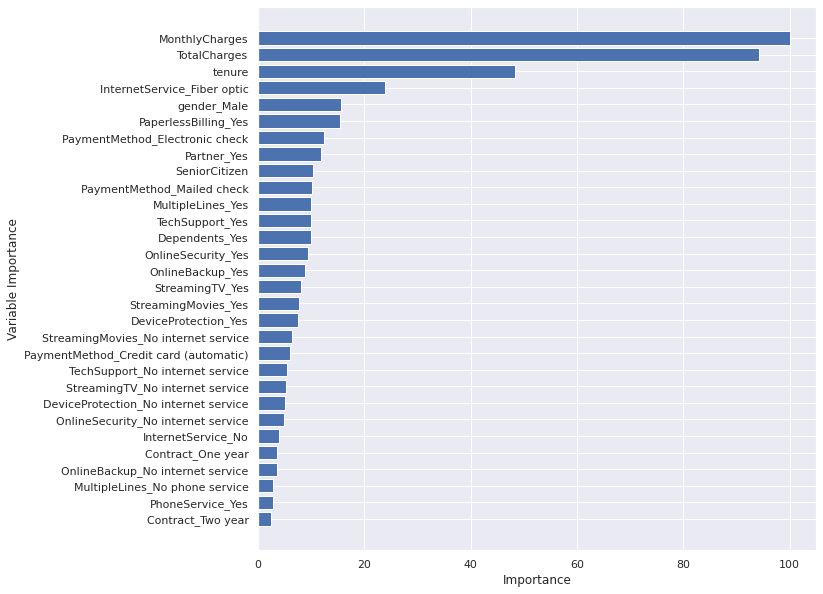

In [41]:
feature_importance_standard = rfc_standard.feature_importances_
feature_importance_standard = 100.0 * (feature_importance_standard / feature_importance_standard.max())
sorted_idx = np.argsort(feature_importance_standard)
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance_standard[sorted_idx], align='center')
plt.yticks(pos, Xtest_dummies.columns[sorted_idx], )
plt.xlabel("Importance")
plt.ylabel('Variable Importance')
plt.show()

##Below I produce a scatter plot and an ROC curve plot with AUC scores to graphically represent how the models performed.

In [42]:
list_model_tests = ['logreg_year1model', 'rfc_year1model']
list_ypred_tests = [ypred_test_standard, ypred_test_rfc_standard]
dict_for_pred_scores = {}
list_recall_scores = []
list_accuracy_scores = []

for ypred in list_ypred_tests:
  recallscore = recall_score(ytest, ypred) * 100
  list_recall_scores.append(recallscore)
  accuracyscore = accuracy_score(ytest, ypred) * 100
  list_accuracy_scores.append(accuracyscore)

dict_for_pred_scores['model'] = list_model_tests
dict_for_pred_scores['recall_score'] = list_recall_scores
dict_for_pred_scores['accuracy_score'] = list_accuracy_scores
df_model_scores = pd.DataFrame.from_dict(dict_for_pred_scores)
df_model_scores.to_csv('year1model_scores.csv')
df_model_scores

,model,recall_score,accuracy_score
0,logreg_year1model,67.953668,70.932358
1,rfc_year1model,62.548263,69.469835


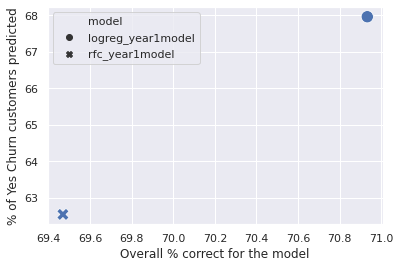

In [43]:
ax = sns.scatterplot(x="accuracy_score", y="recall_score",
                    style="model", data=df_model_scores, s=150)
_ = plt.ylabel('% of Yes Churn customers predicted')
_ = plt.xlabel('Overall % correct for the model')
plt.show()

This is for the 2 different models using the 1st year customer data


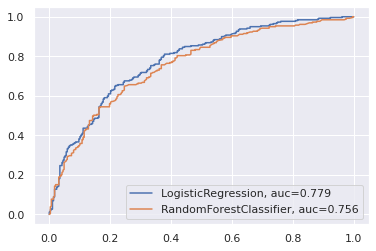

In [44]:
ypred_prob_logreg = logreg_pipeline_standard.predict_proba(Xtest_dummies)[::,1]
fpr_logreg, tpr_logreg, _ = roc_curve(ytest, ypred_prob_logreg)
auc_logreg = roc_auc_score(ytest, ypred_prob_logreg)

ypred_prob_rfc = rfc_pipeline_standard.predict_proba(Xtest_dummies)[::,1]
fpr_rfc, tpr_rfc, _ = roc_curve(ytest, ypred_prob_rfc)
auc_rfc = roc_auc_score(ytest, ypred_prob_rfc)

_ = plt.plot(fpr_logreg, tpr_logreg, label='LogisticRegression, auc='+ str(round(auc_logreg, 3)))
_ = plt.plot(fpr_rfc, tpr_rfc, label='RandomForestClassifier, auc='+ str(round(auc_rfc, 3)))
plt.legend(loc='best')
print("This is for the 2 different models using the 1st year customer data")
plt.show()

##Neither of these models performed better at predicting the Yes recall or at having a higher overall accuracy than earlier models (see Capstone2_LogisticRegression_imbalanceddata and Capstone2_randomforest). 

In [45]:
from google.colab import files
files.download('year1model_scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>